In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.3f}'.format)
%matplotlib inline

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

Sometimes it’s better to know about the data that you’re using and we can use DESCR to know the basic description of the data-set.

In [3]:
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

From this you now know that this data-set has 30 features like smoothness, radius etc. The number of instances are 569 and out of them 212 are malignant and rest are benign. The target variables are listed as 0 and 1 and just to make sure 0 represents malignant and vice-versa one can check -

In [5]:
len(cancer.data[cancer.target==0])

212

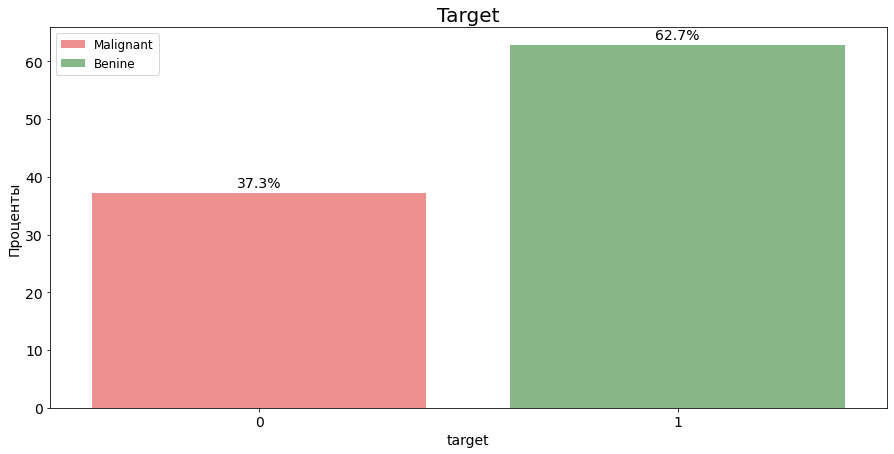

In [6]:
# нормирование на размер датасета
norm_target = (pd.DataFrame(cancer.target, columns=['index'])
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(15, 7), facecolor='white')

ax = sns.barplot(x='index', y='percent', data=norm_target, palette=['r','g'], alpha=0.5)

# Вывод значений над графиками - annotate()
# В цикле смотрим каждый столбец графика и на нем отмечаем значения
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center', # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points', # точка смещения относительно координаты
                fontsize=14)

plt.title('Target', fontsize=20)

plt.xlabel('target', fontsize=14)
plt.ylabel('Проценты', fontsize=14)
ax.legend((ax.patches[0], ax.patches[1]), ('Malignant', 'Benine'), fontsize=12)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

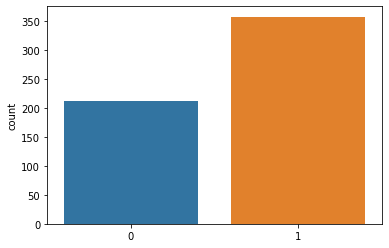

In [7]:
sns.countplot(x=cancer.target)
plt.show()

To know more about how the features affect the target, we can plot histograms of malignant and benign classes. If the two histograms are separated based on the feature, then we can say that the feature is important to discern the instances.

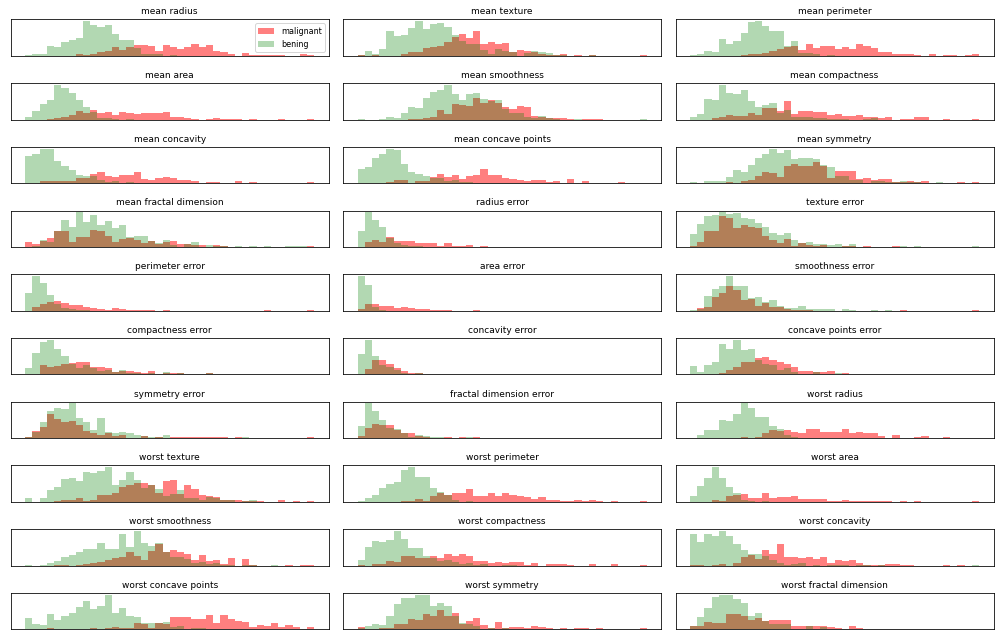

In [8]:
# 3 columns each containing 10 axes, total 30 features
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(14,9))
fig.patch.set_facecolor('white')

malignant = cancer.data[cancer.target==0] #define malignant
bening = cancer.data[cancer.target==1] #define bening

ax = axes.ravel() #flat axes with numpy ravel
for i in range(30):
    _, bins = np.histogram(cancer.data[:,i], bins=40) #ранжируем bins по общему датасету
    #red color for malignant class, green color for bening class
    #alpha is for transparency in the overlapped region
    ax[i].hist(malignant[:,i], bins=bins, color='r', alpha=0.5)
    ax[i].hist(bening[:,i], bins=bins, color='g', alpha=0.3)
    ax[i].set_title(cancer.feature_names[i], fontsize=9)
    ax[i].set_xticks(())
    ax[i].set_yticks(())

ax[0].legend(['malignant','bening'], loc='best', fontsize=8)
plt.tight_layout()

plt.show()    

Now from these histograms we see that features like- mean fractal dimension has very little role to play in discerning malignant from benign, but worst concave points or worst perimeter are useful features that can give us strong hint about the classes of cancer data-set. Histogram plots are essential in our astrophysics studies as they are often used to separate models. I couldn’t resist the temptation to bring it up here. So if your data has only one feature e.g. worst perimeter, it can be good enough to separate malignant from benign case.

Before using PCA to these cancer data-set, let’s understand very simply what PCA actually does. We know that in a data-set there are high possibilities for some features to be correlated. Let’s see some example plots from cancer data set —

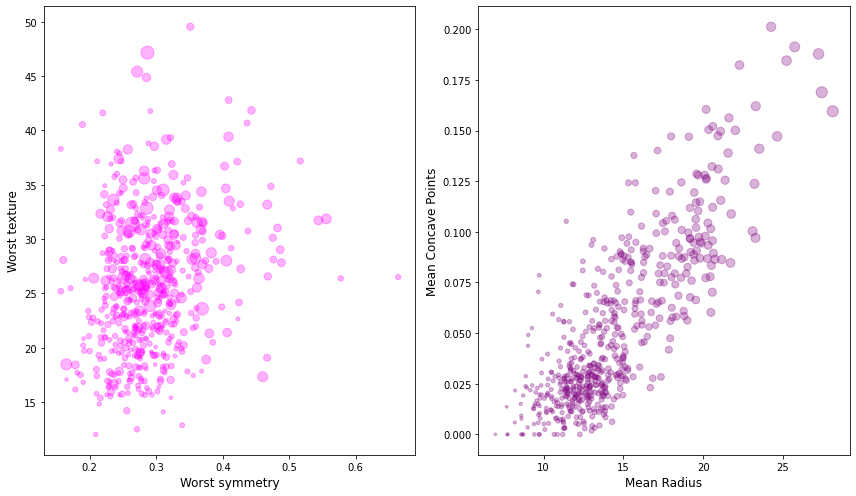

In [9]:
cancer_df = pd.DataFrame(cancer.data, columns=cancer.feature_names) #just conver data to pandas dataframe
fig,ax=plt.subplots(figsize=(12,7))
fig.patch.set_facecolor('white')
plt.subplot(1,2,1) #first plot
plt.scatter(cancer_df['worst symmetry'], cancer_df['worst texture'],\
            s=cancer_df['worst area']*0.05, color='magenta', label='check', alpha=0.3)
plt.xlabel('Worst symmetry', fontsize=12)
plt.ylabel('Worst texture', fontsize=12)
plt.subplot(1,2,2) #second plot
plt.scatter(cancer_df['mean radius'], cancer_df['mean concave points'],\
            s=cancer_df['mean area']*0.05, color='purple', label='check', alpha=0.3)
plt.xlabel('Mean Radius', fontsize=12)
plt.ylabel('Mean Concave Points', fontsize=12)
plt.tight_layout()
plt.show()

Now hopefully you can already understand which plot shows strong correlation between the features.

PCA is essentially a method that reduces the dimension of the feature space in such a way that new variables are orthogonal to each other (i.e. they are independent or not correlated). 

Anyway, from the cancer data-set we see that it has 30 features, so let’s reduce it to only 3 principal features and then we can visualize the scatter plot of these new independent variables.  

Before applying PCA, we scale our data such that each feature has unit variance. This is necessary because fitting algorithms highly depend on the scaling of the features. Here we use the StandardScalermodule for scaling the features individually. StandardScalersubtracts the mean from each features and then scale to unit variance.

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #instantiate
#scaler.fit(cancer.data) #compute the mean and the standard which will be used in the next command
#X_scaled = scaler.transform(cancer.data)

X_scaled = scaler.fit_transform(cancer.data)

pd.DataFrame(X_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,...,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000
mean,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,...,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,...,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001
min,-2.030,-2.229,-1.985,-1.454,-3.112,-1.610,-1.115,-1.262,-2.744,-1.820,...,-1.727,-2.224,-1.693,-1.222,-2.683,-1.444,-1.306,-1.745,-2.161,-1.602
25%,-0.689,-0.726,-0.692,-0.667,-0.711,-0.747,-0.744,-0.738,-0.703,-0.723,...,-0.675,-0.749,-0.690,-0.642,-0.691,-0.681,-0.757,-0.756,-0.642,-0.692
50%,-0.215,-0.105,-0.236,-0.295,-0.035,-0.222,-0.342,-0.398,-0.072,-0.178,...,-0.269,-0.044,-0.286,-0.341,-0.047,-0.270,-0.218,-0.223,-0.127,-0.216
75%,0.469,0.584,0.500,0.364,0.636,0.494,0.526,0.647,0.531,0.471,...,0.522,0.658,0.540,0.358,0.598,0.540,0.531,0.713,0.450,0.451
max,3.971,4.652,3.976,5.251,4.771,4.568,4.244,3.928,4.485,4.911,...,4.094,3.886,4.287,5.930,3.955,5.113,4.701,2.686,6.046,6.847


(array([  5.,  43.,  93., 150., 143.,  78.,  34.,  19.,   1.,   3.]),
 array([-2.68269492, -2.01888802, -1.35508111, -0.69127421, -0.02746731,
         0.6363396 ,  1.3001465 ,  1.9639534 ,  2.6277603 ,  3.29156721,
         3.95537411]),
 <BarContainer object of 10 artists>)

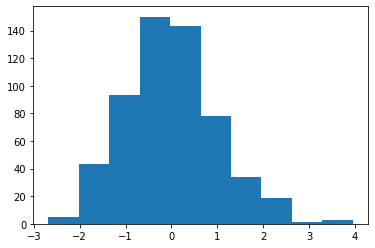

In [11]:
plt.hist(X_scaled[:,24])

Now we’re ready to apply PCA on this scaled data-set. We start as before with StandardScaler, where we instantiate, then fit and finally transform the scaled data. While applying PCA you can mention how many principal components you want to keep.

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
#let's check the shape of X_pca array
print('shape of X_pca ',X_pca.shape)

shape of X_pca  (569, 3)


Now we have seen that the data have only 3 features. Drawback of PCA is it’s almost impossible to tell how the initial features (here 30 features) combined to form the principal components. Now one important point to note is that I have chosen 3 components instead of 2, which could have reduced the dimension of the data-set even more. Can you choose n_components=2? [Think about it for sometime as a mini-exercise. Can you think of some method to test this ?]  
You can check by measuring the variance ratio of the principal components.

In [13]:
ex_variance = np.var(X_pca, axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio

array([0.60950217, 0.2611802 , 0.12931763])

So here you can see that the first 2 components contributes to 87% of the total variance. So it’s good enough to choose only 2 components. Okay, now with these first 2 components, we can jump to one of the most important application of PCA, which is data visualization.  
Now, since the PCA components are orthogonal to each other and they are not correlated, we can expect to see malignant and benign classes as distinct. Let’s plot the malignant and benign classes based on the first two principal components

In [14]:
pd.DataFrame(X_pca).describe()

,0,1,2
count,569.000,569.000,569.000
mean,0.000,0.000,0.000
std,3.648,2.388,1.680
min,-5.566,-7.776,-4.880
25%,-2.757,-1.500,-1.017
50%,-1.174,-0.196,-0.156
75%,2.509,1.228,0.857
max,16.319,12.573,10.112


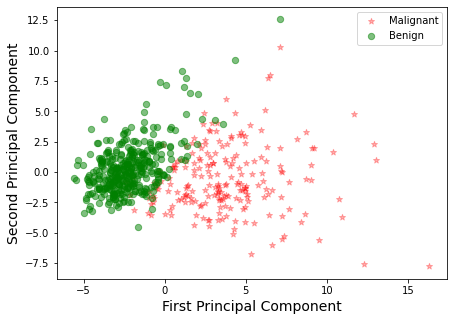

In [15]:
Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels=cancer.target
cdict={0:'red',1:'green'}
labl={0:'Malignant',1:'Benign'}
marker={0:'*',1:'o'}
alpha={0:.3, 1:.5}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
    ix=np.where(labels==l)
    ax.scatter(Xax[ix],Yax[ix],c=cdict[l],s=40,\
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()
# please check the scatter plot of the remaining component and you will understand the difference

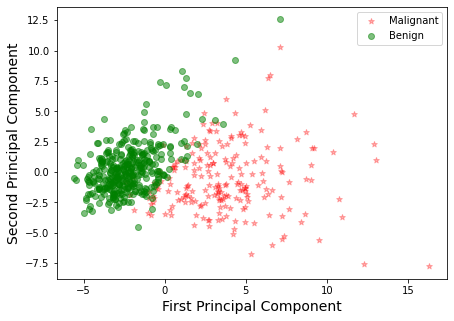

In [16]:
Xax=X_pca[:,0]
Yax=X_pca[:,1]
Zax=X_pca[:,2]
labels=cancer.target
cdict={0:'red',1:'green'}
labl={0:'Malignant',1:'Benign'}
marker={0:'*',1:'o'}
alpha={0:.3, 1:.5}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
    ix=np.where(labels==l)
    ax.scatter(Xax[ix],Yax[ix],c=cdict[l],
           label=labl[l],marker=marker[l],alpha=alpha[l])
# for loop ends
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.legend()
plt.show()

Looks great, isn’t it? The two classes are well separated with the first 2 principal components as new features. As good as it seems like even a linear classifier could do very well to identify a class from the test set.  
On a separate post, I have discussed how to apply a pipeline consisting of PCA and Support Vector Classifier to and draw the decision function for this same data-set.  
One important feature is how the malignant class is spread out compared to benign and take a look back to those histogram plots. Can you find some similarity?

These principal components are calculated only from features and no information from classes are considered. So PCA is unsupervised method and it’s difficult to interpret the two axes as they are some complex mixture of the original features. We can make a heat-plot to see how the features mixed up to create the components.

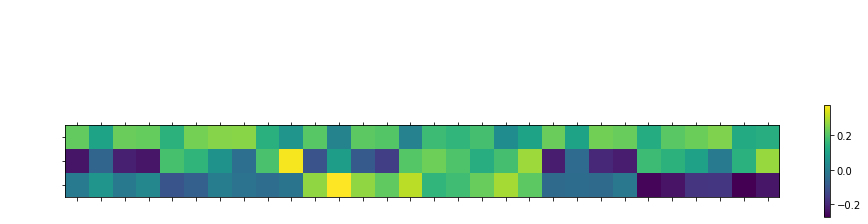

In [17]:
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2],['1st Comp','2nd Comp','3rd Comp'],fontsize=10, color='w')
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)),cancer.feature_names,rotation=65,ha='left', color='w')
#plt.tight_layout()
plt.show()

It’s actually difficult to understand how correlated the original features are from this plot but we can always map the correlation of the features using seabornheat-plot. But still, check the correlation plots before and see how 1st principal component is affected by mean concave points and worst texture. Can you tell which feature contribute more towards the 1st PC ?
Here I show the correlation plot of ‘worst’ values of the features.

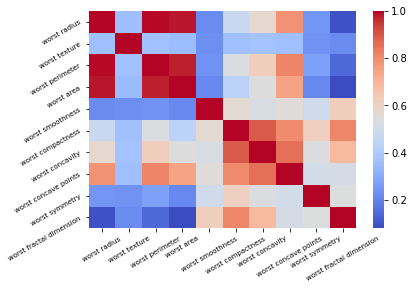

In [18]:
feature_worst=list(cancer_df.columns[20:31]) # select the 'worst' features
s=sns.heatmap(cancer_df[feature_worst].corr(),cmap='coolwarm') 
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=7)
s.set_xticklabels(s.get_xticklabels(),rotation=30,fontsize=7)
plt.show()

So to end this meditation let’s summarize what we have done and learnt  

1. Why PCA rather than just feature analysis ? (Answer hints: large data-set, many features, let’s reduce dimension of feature space)  
2. We started our example with cancer data-set and found 30 features with 2 classes.
3. To apply PCA on this data-set, first we scale all the features and then apply fit_transformmethod of PCA (with 3 principal components) on the scaled features.
4. We show that out of those 3 principal components, 2 contribute to 87% of the total variance.
5. Based on these 2 principal components we visualize the data and see very clear separation between ‘Malignant’ and ‘Benign’ classes.

Hope this will help you to grasp few concepts and guide you to effectively apply PCA on your data-set. For exercise you can try immediately on Boston house data (13 features) and see the results. Go through carefully again and remember the essential concepts about initially correlated features to finally independent principal components.  
This post which is influenced from Muller’s book, was my stepping stone to an attempt to separate two astrophysical scenarios (Pulsar and Dark Matter) with cosmic ray measured by CALET detector. You can find all the details in my github profile. If you are interested in the parameters and detail description please let me know. A separate analysis of our work using Akaike criterion was selected for publication in International Jouranl of Modern Physics D.

Check the references below for further reading
1. In-depth analysis of how PCA works: a-one-stop-shop-for-pca
2. Machine Learning in Action; Peter Harrington: Manning Publications, pp-270–278.
3. PCA and Image Reconstruction